## Downloading all of the dataset

In [ ]:
# Download all of the dataset - Option 1
!curl -L -O https://isic-archive.com/api/v1/image/download?include=all

In [ ]:
# Download all of the dataset - Option 2
!nohup curl -L -O https://isic-archive.com/api/v1/image/download?include=all &

In [ ]:
# Download all of the dataset - Option 3
!nohup lftp -c 'set net:idle 10 
!      set net:max-retries 0
!      set net:reconnect-interval-base 3
!      set net:reconnect-interval-max 3
!      pget -n 10 -c "https://isic-archive.com/api/v1/image/download?include=all"' &

In [ ]:
# Download all of the dataset - Option 4

!lftp -c 'set net:idle 10
!      set net:max-retries 0
!      set net:reconnect-interval-base 3
!      set net:reconnect-interval-max 3
!      pget -n 10 -c "https://isic-archive.com/api/v1/image/download?include=all"'

In [ ]:
# Unzip Downloaded file

!unzip <downloaded_file_name> # Unzip the downloaded images

## Data Cleaning

In [15]:
import glob
import pandas as pd
import numpy as np
import tensorflow as tf

pd.options.display.max_columns = 100

from src.functions import *
AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

In [18]:
## This code will only work if you have all the images already downloaded on your local drive
img_url = sorted(glob.glob('data/ISIC-images'+"/*.jpg"))
csv_names = [i for i in glob.glob('data'+'/*.csv')]
df = pd.read_csv('data/metadata.csv')

short=[]
for i in img_url:
    short.append(i[17:-4])
img_name = pd.Series(short,name='name')

df = pd.merge(df, img_name, on='name', how='inner')
df['image'] = img_url

df = df[['meta.clinical.diagnosis', 'image']]
df_na = df.copy()
df = df[df['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
df.columns = ['diagnosis', 'image']
df['diagnosis'] = (df['diagnosis'] == 'melanoma').astype(int)

## Deleted null values from dataset

In [3]:
df_na[df_na['meta.clinical.diagnosis'].isna()]

,meta.clinical.diagnosis,image
257,NaN,data/ISIC-images/ISIC_0000257.jpg
454,NaN,data/ISIC-images/ISIC_0000454.jpg
9892,NaN,data/ISIC-images/ISIC_0009892.jpg
9893,NaN,data/ISIC-images/ISIC_0009893.jpg
9924,NaN,data/ISIC-images/ISIC_0009924.jpg
...,...,...
13786,NaN,data/ISIC-images/ISIC_0024202.jpg
13787,NaN,data/ISIC-images/ISIC_0024203.jpg
13788,NaN,data/ISIC-images/ISIC_0024204.jpg
13789,NaN,data/ISIC-images/ISIC_0024205.jpg


## Create Test Set and Save processed images

In [27]:
# Code to create X and y.
X, y = create_X_y(df)

In [22]:
# Save to local drive
np.save('data/100x100.npy', X)
np.save('data/diagnosis.npy', y)

---

## OPTIONAL: Create a Sample Dataset

### Creating Sample Set with 1000 images (Balanced distribution)

In [8]:
# Train Set
path = "data_sample/img_sample"
negataive_img_names = sorted(glob.glob(path+"/0/*.jpg"))
positive_img_names = sorted(glob.glob(path+"/1/*.jpg"))

negative_csv =[i for i in glob.glob('data_sample/metadata_sample/0/*.csv')]
positive_csv =[i for i in glob.glob('data_sample/metadata_sample/1/*.csv')]

train_neg = pd.concat([pd.read_csv(f) for f in negative_csv]).sort_values('name').reset_index(drop=True)
train_pos = pd.concat([pd.read_csv(f) for f in positive_csv]).sort_values('name').reset_index(drop=True)

train_neg['image'] = negataive_img_names
train_pos['image'] = positive_img_names

In [9]:
meta_train = pd.concat([train_neg, train_pos]).reset_index(drop=True)
lbl_img = meta_train[['meta.clinical.diagnosis', 'image']]
lbl_img_cl = lbl_img[lbl_img['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
lbl_img_cl.columns = ['diagnosis', 'image']
lbl_img_cl['diagnosis'] = (lbl_img_cl['diagnosis'] == 'melanoma').astype(int)
fileimages = lbl_img_cl['image']

In [10]:
## Create X and y for Train set.
y = np.asarray(lbl_img_cl['diagnosis'])
X = []
for i in fileimages:
    image = load_and_preprocess_image(i)
    X.append(np.asarray(image))
X = np.asarray(X)

#### Saving converted images to numpy file

In [11]:
np.save('data_sample/sample_100x100.npy', X)
np.save('data_sample/sample_diagnosis.npy', y)

#### Plot Sample Images

In [23]:
## Non-cancer images
path_ds_0 = tf.data.Dataset.from_tensor_slices(fileimages)
image_ds_0 = path_ds_0.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

## Cancer images
path_ds_1 = tf.data.Dataset.from_tensor_slices(fileimages[::-1])
image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

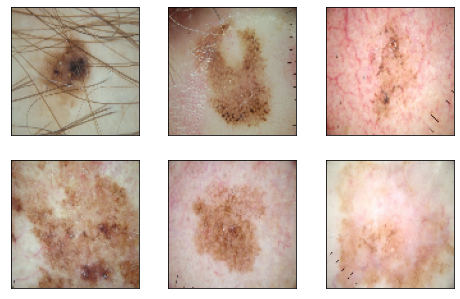

In [28]:
plt.figure(figsize = (8,8))
for n, image in enumerate(image_ds_1.take(6)):
    plt.subplot(3,3,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])



997    data_sample/img_sample/1/ISIC_0011288.jpg
996    data_sample/img_sample/1/ISIC_0011286.jpg
995    data_sample/img_sample/1/ISIC_0011285.jpg
994    data_sample/img_sample/1/ISIC_0011277.jpg
993    data_sample/img_sample/1/ISIC_0011276.jpg
                         ...                    
4      data_sample/img_sample/0/ISIC_0000006.jpg
3      data_sample/img_sample/0/ISIC_0000005.jpg
2      data_sample/img_sample/0/ISIC_0000003.jpg
1      data_sample/img_sample/0/ISIC_0000001.jpg
0      data_sample/img_sample/0/ISIC_0000000.jpg
Name: image, Length: 998, dtype: object